In [ ]:
!pip install pyconll

In [ ]:
!pip install torchview

In [ ]:
!mkdir ./datasets/
!wget -O ./datasets/ru_syntagrus-ud-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-a.conllu
!wget -O ./datasets/ru_syntagrus-ud-dev.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu

In [4]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pyconll

import re
import torch
import torch.nn as nn
import torch.optim as optim

from torchview import draw_graph

In [5]:
full_train = pyconll.load_from_file('./datasets/ru_syntagrus-ud-train.conllu')
full_test = pyconll.load_from_file('./datasets/ru_syntagrus-ud-dev.conllu')

In [6]:
for sent in full_train[:2]:
    for token in sent:
        print(token.form, token.upos)
    print()

Анкета NOUN
. PUNCT

Начальник NOUN
областного ADJ
управления NOUN
связи NOUN
Семен PROPN
Еремеевич PROPN
был AUX
человек NOUN
простой ADJ
, PUNCT
приходил VERB
на ADP
работу NOUN
всегда ADV
вовремя ADV
, PUNCT
здоровался VERB
с ADP
секретаршей NOUN
за ADP
руку NOUN
и CCONJ
иногда ADV
даже PART
писал VERB
в ADP
стенгазету NOUN
заметки NOUN
под ADP
псевдонимом NOUN
" PUNCT
Муха NOUN
" PUNCT
. PUNCT



In [7]:
LENS = [len(token.form) for sent in full_train for token in sent] + \
       [len(str(token.form)) for sent in  full_test for token in sent]
MAX_ORIG_TOKEN_LEN = max(LENS)
print(MAX_ORIG_TOKEN_LEN)

31


In [8]:
import re

def parse_chars(sent2):
    return list(sent2.lower())

all_train_texts = [' '.join(token.form for token in sent) for sent in full_train]
train_char_tokenized = [parse_chars(sent) for sent in all_train_texts]
concat_chars = [j for i in train_char_tokenized for j in i]

unique_chars=set(concat_chars)
MAX_UNIQUE_CHARS=len(unique_chars)
char_vocab={s:i for i,s in enumerate(unique_chars)}

In [9]:
UNIQUE_TAGS = ['<NOTAG>'] + sorted({token.upos for sent in full_train for token in sent if token.upos})
label2id = {label: i for i, label in enumerate(UNIQUE_TAGS)}
MAX_UNIQUE_TAGS=len(UNIQUE_TAGS)

#revert dictionaries
id2label=dict()
for i,val in label2id.items(): id2label[val]=i
vocab_char=dict()
for i,val in char_vocab.items(): vocab_char[val]=i
id2label

{0: '<NOTAG>',
 1: 'ADJ',
 2: 'ADP',
 3: 'ADV',
 4: 'AUX',
 5: 'CCONJ',
 6: 'DET',
 7: 'INTJ',
 8: 'NOUN',
 9: 'NUM',
 10: 'PART',
 11: 'PRON',
 12: 'PROPN',
 13: 'PUNCT',
 14: 'SCONJ',
 15: 'SYM',
 16: 'VERB',
 17: 'X'}

In [10]:
def words2array(sentences, char2id, label2id, max_token_len):
    inputs =[] #np.zeros((len(words), max_token_len + 2), dtype=np.long)
    targets =[] # np.zeros((len(words)), dtype=np.long)
    words=[]
    for sent_i, sent in enumerate(sentences):
        for token_i, token in enumerate(sent):
             targets.append(label2id.get(token.upos, 0))
             charray=np.zeros(max_token_len + 2)
             # print('check',token.form)
             if(token.form):
              for char_i, char in enumerate(token.form.lower()):
                charray[char_i + 1] = char2id.get(char, 0)
             inputs.append(charray)
             words.append(token.form)
    return np.array(inputs).astype(int), np.array(targets).astype(int), np.array(words)

In [11]:
train_inputs, train_labels, words = words2array(full_train,
                                                char_vocab,
                                                label2id,
                                                MAX_ORIG_TOKEN_LEN)

test_inputs, test_labels, words2 = words2array(full_test,
                                              char_vocab,
                                              label2id,
                                              MAX_ORIG_TOKEN_LEN)

In [12]:
print(train_inputs.shape)
print(train_inputs[0])
print(train_inputs[1])
print(train_inputs[2])
print(train_inputs[3])

(426182, 33)
[ 0 81 33 58 18 55 81  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]
[ 0 49  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]
[ 0 33 81 10 81 57 35 33 36 58  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]
[ 0 31 69 57 81 40 55 33 31  1 31  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]


In [13]:
 def create_windows(data, labels, window_size=5):
    half_window = window_size // 2

    # Добавляем паддинги нулями
    padded_data = np.pad(
        data,
        (half_window, half_window),
        mode='constant',
        constant_values=0
    )
    padded_labels = np.pad(
        labels,
        (half_window, half_window),
        mode='constant',
        constant_values=0
    )

    # Создаем окна для каждого исходного элемента
    windows = []
    new_labels = []

    for i in range(len(data)):
        # Центральная позиция в расширенных данных
        center = i + half_window
        # Извлекаем окно
        window = padded_data[center - half_window : center + half_window + 1]
        windows.append(window)
        # Сохраняем метку центрального элемента
        new_labels.append(padded_labels[center])

    return np.array(windows), np.array(new_labels)

In [14]:
t1, t2 = create_windows(train_inputs, train_labels)
train_inputs, train_labels = t1, t2

t1, t2 = create_windows(test_inputs, test_labels)
test_inputs, test_labels = t1, t2

In [16]:
print(train_inputs[0])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 81 33 58 18 55 81  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 49  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 33 81 10 81 57 35 33 36 58  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [52]:
class MyModel(nn.Module):
    def __init__(self, InDim=3, Tags=1):
        super().__init__()
        self.EMBSIZE = 3
        self.InDim = InDim
        self.Tags = Tags

        self.emb = nn.Embedding(self.InDim, self.EMBSIZE)

        self.conv1 = nn.Conv2d(1,20,kernel_size=3)
        self.act1 = nn.ReLU()
        self.drop = nn.Dropout(0.3)

        self.pos_selector = nn.Linear(5, 1)
        self.f1 = nn.Flatten(start_dim=1, end_dim=3)
        self.solve = nn.Linear(700, self.Tags)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size*5, 37)

        x = x.to(int)
        x = self.emb(x)
        x = x.unsqueeze(1)
        x = self.act1(self.conv1(x))
        x = x.view(batch_size, 5, 20*35)

        x = self.pos_selector(x.permute(0, 2, 1))
        x = x.squeeze()

        x = self.drop(x)
        x = self.solve(x)
        return x

model = MyModel(MAX_UNIQUE_CHARS, MAX_UNIQUE_TAGS)
print(model)

MyModel(
  (emb): Embedding(92, 3)
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (act1): ReLU()
  (drop): Dropout(p=0.3, inplace=False)
  (pos_selector): Linear(in_features=5, out_features=1, bias=True)
  (f1): Flatten(start_dim=1, end_dim=3)
  (solve): Linear(in_features=700, out_features=18, bias=True)
  (sm): Softmax(dim=1)
)


In [34]:
print(MAX_UNIQUE_CHARS)
print(MAX_UNIQUE_TAGS)
print(MAX_ORIG_TOKEN_LEN)

92
18
31


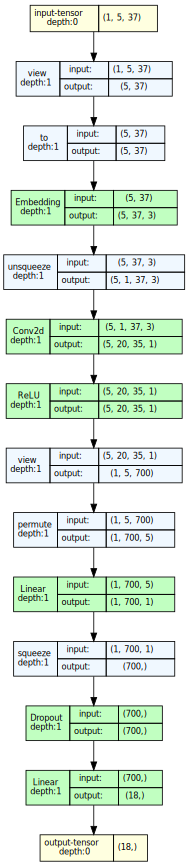

In [53]:
from torchview import draw_graph
model_graph = draw_graph(model,
                         input_size=(1, 5, MAX_ORIG_TOKEN_LEN+6),
                         expand_nested=True)
model_graph.visual_graph

In [54]:
import torch.nn.functional as F
print(train_inputs.shape)
train_labels_c = F.one_hot(
    torch.tensor(train_labels),
    num_classes=MAX_UNIQUE_TAGS
).to(torch.float32)

(426182, 5, 37)


In [55]:
Xtr = torch.tensor(train_inputs)
Ytr_c = train_labels_c

In [56]:
l = Xtr.shape[0]
Xt, Xv, Xtest = Xtr[:l*3//5], Xtr[l*3//5:l*4//5], Xtr[l*4//5:]
Yt, Yv, Ytest = Ytr_c[:l*3//5], Ytr_c[l*3//5:l*4//5], Ytr_c[l*4//5:]

In [57]:
print(Xt.shape)
print(Xt[0:64].shape)
print(Yt.shape)

torch.Size([255709, 5, 37])
torch.Size([64, 5, 37])
torch.Size([255709, 18])


In [58]:
print('cuda' if torch.cuda.is_available() else 'cpu')

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_epochs = 10
batch_size = 32
patience = 3
best_epoch, old_loss = 0, 1e100

for epoch in range(n_epochs):
    for i in range(0, len(Xt), batch_size):
        Xbatch = Xt[i:i+batch_size].cuda()
        y_pred = model(Xbatch)
        ybatch = Yt[i:i+batch_size].cuda()
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss = 0.0
    n = 0
    for i in range(0, len(Xv), batch_size):
        Xbatch = Xv[i:i+batch_size].cuda()
        y_pred = model(Xbatch)
        ybatch = Yv[i:i+batch_size].cuda()
        loss += loss_fn(ybatch, y_pred)
        n += 1
    loss = loss / n
    if loss < old_loss:
            best_epoch = epoch
            old_loss = loss
            best_model = model
    if epoch > best_epoch + patience:
            break

    print(f'Finished epoch {epoch}, latest loss {loss}')

cuda
Finished epoch 0, latest loss -110.888916015625
Finished epoch 1, latest loss -184.9822998046875
Finished epoch 2, latest loss -235.13816833496094
Finished epoch 3, latest loss -259.2043151855469
Finished epoch 4, latest loss -284.6068420410156
Finished epoch 5, latest loss -308.73406982421875
Finished epoch 6, latest loss -318.3114013671875
Finished epoch 7, latest loss -335.056640625
Finished epoch 8, latest loss -347.6673889160156
Finished epoch 9, latest loss -367.69024658203125


In [59]:
yp = best_model(Xtest.cuda()).cpu().detach().numpy()
yp = np.argmax(yp, axis=1)
yt = np.argmax(Ytest, axis=1)

In [60]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(yt, yp))
print(confusion_matrix(yt, yp))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        84
           1       0.75      0.70      0.73      8753
           2       0.87      0.96      0.91      7755
           3       0.64      0.43      0.52      4563
           4       0.77      0.90      0.83       690
           5       0.85      0.95      0.90      2955
           6       0.75      0.57      0.65      2168
           7       0.00      0.00      0.00         2
           8       0.70      0.85      0.77     20791
           9       0.69      0.80      0.74      1254
          10       0.81      0.71      0.76      2755
          11       0.76      0.77      0.76      3829
          12       0.61      0.10      0.17      2826
          13       1.00      1.00      1.00     15429
          14       0.70      0.90      0.79      1726
          15       0.92      0.98      0.95       176
          16       0.77      0.66      0.71      9436
          17       0.00    

In [61]:
def words2array2(all_words, char2id, max_token_len):
    inputs =[]
    words=[]
    for token_i, token in enumerate(all_words):
             charray=np.zeros(max_token_len + 2)
             if(token):
              for char_i, char in enumerate(token.lower()):
                charray[char_i + 1] = char2id.get(char, 0)
             inputs.append(charray)
             words.append(token)
    return np.array(inputs).astype(int), np.array(words)

In [62]:
all_train_texts = [' '.join(token.form for token in sent) for sent in full_train]
f = open('text.txt', mode='r', encoding='utf-8')
l = f.read()
f.close()

all_train_texts = ''.join(l)
print(all_train_texts)
input_words = re.split(r'\W+', all_train_texts)

# Создаем тестовые данные
test_inputs2, words2 = words2array2(input_words,
                                    char_vocab,
                                    MAX_ORIG_TOKEN_LEN)

# Создаем фиктивные метки (не используются в предсказании)
dummy_labels = np.zeros(len(test_inputs2))

# Создаем окна
test_windows, _ = create_windows(test_inputs2,
                                 dummy_labels,
                                 window_size=5)

test_windows_tensor = torch.tensor(test_windows).to(torch.int64)
yp = model(test_windows_tensor.cuda()).cpu().detach().numpy()
yp = yp.argmax(axis=1)

# Выводим результаты
for i in range(yp.shape[0]):
    print(words2[i], id2label[yp[i]])

Мама мыла раму. Мыла было мало.
Мама NOUN
мыла NOUN
раму NOUN
Мыла NOUN
было AUX
мало NOUN
 SYM
